# Baseline: Fashion-MNIST

**Goal:** prove the pipeline works before scripting it.

**Plan:**
- Load **Fashion-MNIST** (`torchvision.datasets.FashionMNIST`) with train/test splits.
- Build a **3-layer CNN**: `Conv → ReLU → MaxPool → Conv → ReLU → MaxPool → FC`.
- Train for **5–10 epochs**.
- Track **accuracy** and **loss**.
- Produce a **confusion matrix** (10×10).
- Log training with **TensorBoard**.
- Save artifacts:
  - **Best model weights** → `checkpoints/baseline_fmnist_best.pt`
  - **Metrics JSON** → `reports/metrics.json`

In [2]:
import os
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms

In [3]:
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 128
NUM_WORKERS = 2
SEED = 41

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


In [4]:
FASHION_MNIST_MEAN = 0.2860
FASHION_MNIST_STD = 0.3530

train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((FASHION_MNIST_MEAN,), (FASHION_MNIST_STD,))
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((FASHION_MNIST_MEAN,), (FASHION_MNIST_STD,))
])

In [5]:
train_ds = tv.datasets.FashionMNIST(
    root=DATA_DIR, train=True, download=True, transform=train_tf
)
test_ds = tv.datasets.FashionMNIST(
    root=DATA_DIR, train=False, download=True, transform=test_tf
)

classes = train_ds.classes
print("classes:", classes)
print("train size:", len(train_ds), "test size:", len(test_ds))

100%|██████████| 26.4M/26.4M [00:06<00:00, 4.36MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 334kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.85MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 665kB/s]

classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train size: 60000 test size: 10000


In [ ]:
train_ds_cifar = tv.datasets.CIFAR10(root="data", train=True, download=True)


In [6]:
g = torch.Generator().manual_seed(SEED)  # reproducible shuffling

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, generator=g
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [7]:
xb, yb = next(iter(train_loader))
print("batch shape:", xb.shape)
print("labels shape:", yb.shape)
print("labels min/max:", int(yb.min()), int(yb.max()))
print("dtype:", xb.dtype)

batch shape: torch.Size([128, 1, 28, 28])
labels shape: torch.Size([128])
labels min/max: 0 9
dtype: torch.float32


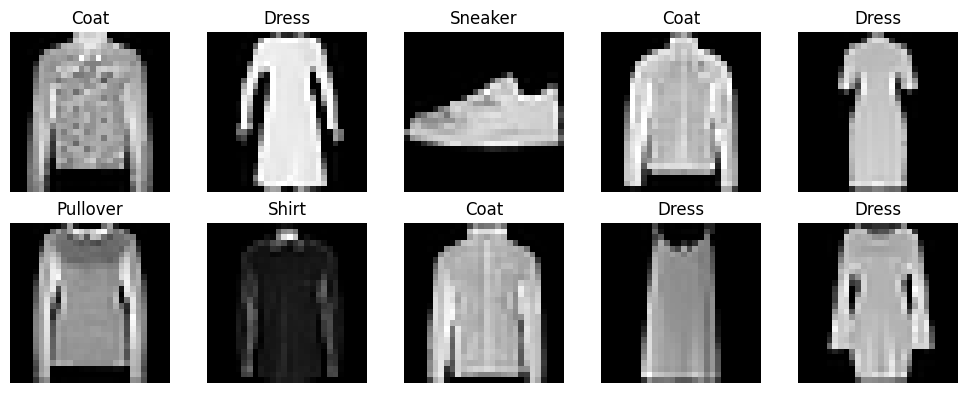

In [8]:
import matplotlib.pyplot as plt

# invert the normalization for visualization
def denorm(x):
    return x * FASHION_MNIST_STD + FASHION_MNIST_MEAN

fig, axes = plt.subplots(2, 5, figsize=(10,4))
for ax, img, lab in zip(axes.ravel(), xb[:10], yb[:10]):
    ax.imshow(denorm(img[0]).cpu().numpy(), cmap="gray")
    ax.set_title(classes[int(lab)])
    ax.axis("off")
plt.tight_layout()
plt.show()

In [9]:
import random
from PIL import Image

# Define the output folder
output_folder = Path("../input")
output_folder.mkdir(parents=True, exist_ok=True)

# Select a random image from the dataset
random_idx = random.randint(0, len(train_ds) - 1)
image, label = train_ds[random_idx]

# Save the image
output_path = output_folder / f"random_image_label_{classes[label]}.png"
image_pil = transforms.ToPILImage()(image)
image_pil.save(output_path)

print(f"Random image saved to {output_path}")

Random image saved to ../input/random_image_label_Ankle boot.png


In [10]:
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(SEED)

class SmallCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits

model = SmallCNN(num_classes=10).to(device)
print(type(model).__name__, "on", device)

xb_device = xb.to(device)
with torch.no_grad():
    out = model(xb_device)
print("logits shape:", out.shape)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"params: total={total_params:,} trainable={trainable_params:,}")

probs = torch.softmax(out, dim=1)
print("prob row sum (sample 0):", float(probs[0].sum()))
print("top-3 classes (sample 0):", probs[0].topk(3).indices.tolist())

SmallCNN on cpu
logits shape: torch.Size([128, 10])
params: total=50,186 trainable=50,186
prob row sum (sample 0): 1.0000001192092896
top-3 classes (sample 0): [3, 1, 2]


In [11]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import time, json
from pathlib import Path

RUN_NAME = f"baseline_fmnist_{int(time.time())}"
writer = SummaryWriter(log_dir=f"../runs/{RUN_NAME}")

CHECKPOINTS_DIR = Path("../checkpoints"); CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = Path("../reports"); REPORTS_DIR.mkdir(parents=True, exist_ok=True)

EPOCHS = 8
best_val_acc = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    # train
    model.train()
    train_loss_sum, train_count = 0.0, 0
    train_acc_sum = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        # stats
        batch_size = yb.size(0)
        train_loss_sum += loss.item() * batch_size
        train_acc_sum  += accuracy(logits, yb) * batch_size
        train_count    += batch_size

    train_loss = train_loss_sum / train_count
    train_acc  = train_acc_sum / train_count

    # eval
    model.eval()
    val_loss_sum, val_count = 0.0, 0
    val_acc_sum = 0.0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)

            batch_size = yb.size(0)
            val_loss_sum += loss.item() * batch_size
            val_acc_sum  += accuracy(logits, yb) * batch_size
            val_count    += batch_size

    val_loss = val_loss_sum / val_count
    val_acc  = val_acc_sum / val_count

    scheduler.step(val_loss)

    # logging
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss,   epoch)
    writer.add_scalar("Acc/train",  train_acc,  epoch)
    writer.add_scalar("Acc/val",    val_acc,    epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

    # Save best by val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": val_acc,
            "val_loss": val_loss,
        }
        torch.save(best_state, CHECKPOINTS_DIR / "baseline_fmnist_best.pt")

# close TB writer
writer.close()
print("Best val_acc:", best_val_acc)

In [ ]:
metrics = {
    "dataset": "FashionMNIST",
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "best_val_acc": float(best_val_acc),
}
with open(REPORTS_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Wrote", REPORTS_DIR / "metrics.json")

Wrote ../reports/metrics.json


In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_targets.append(yb)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)
print("Collected:", all_preds.shape[0], "preds")


Collected: 10000 preds


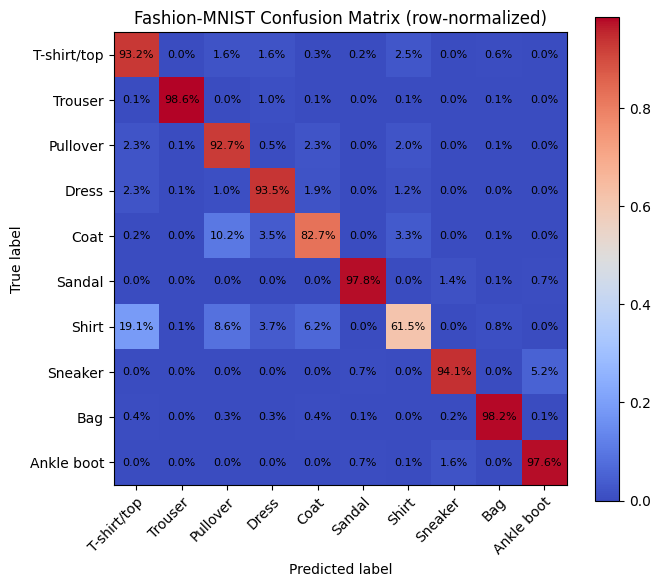

Saved figure to: ../reports/figures/confusion_matrix.png
Updated ../reports/metrics.json


In [ ]:
num_classes = 10
cm_metric = MulticlassConfusionMatrix(num_classes=num_classes)
cm = cm_metric(all_preds, all_targets)  # shape [C, C], row=true, col=pred
cm = cm.numpy()
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm_norm, interpolation="nearest", cmap="coolwarm")
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(num_classes),
    yticks=np.arange(num_classes),
    xticklabels=classes,
    yticklabels=classes,
    ylabel="True label",
    xlabel="Predicted label",
    title="Fashion-MNIST Confusion Matrix (row-normalized)"
)

# rotate x tick labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotate cells with percentages
for i in range(num_classes):
    for j in range(num_classes):
        val = cm_norm[i, j]
        ax.text(j, i, f"{val*100:.1f}%", ha="center", va="center", fontsize=8)

fig.tight_layout()
fig_path = FIG_DIR / "confusion_matrix.png"
plt.savefig(fig_path, dpi=200)
plt.show()
print("Saved figure to:", fig_path)

# save both raw counts and normalized values
np.save(FIG_DIR / "confusion_matrix_counts.npy", cm)
np.save(FIG_DIR / "confusion_matrix_norm.npy", cm_norm)

metrics_path = REPORTS_DIR / "metrics.json"
try:
    with open(metrics_path) as f:
        metrics = json.load(f)
except FileNotFoundError:
    metrics = {}

metrics.update({
    "confusion_matrix_counts_path": str(FIG_DIR / "confusion_matrix_counts.npy"),
    "confusion_matrix_norm_path": str(FIG_DIR / "confusion_matrix_norm.npy"),
    "confusion_matrix_figure": str(fig_path),
})
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("Updated", metrics_path)


Working dir: /Users/stefanoracca/Desktop/projects/computer-vision-explainable-cnn
Using checkpoint: checkpoints/smallcnn_aug_fmnist/best.ckpt
Saved: reports/smallcnn_aug_fmnist/explain_direct
Saved: reports/smallcnn_aug_fmnist/explain_direct
Saved: reports/smallcnn_aug_fmnist/explain_direct
Saved overlays: ['reports/smallcnn_aug_fmnist/explain_direct/gradcam_top1_class3_Dress.png', 'reports/smallcnn_aug_fmnist/explain_direct/gradcam_top1_class4_Coat.png', 'reports/smallcnn_aug_fmnist/explain_direct/gradcam_top1_class8_Bag.png']


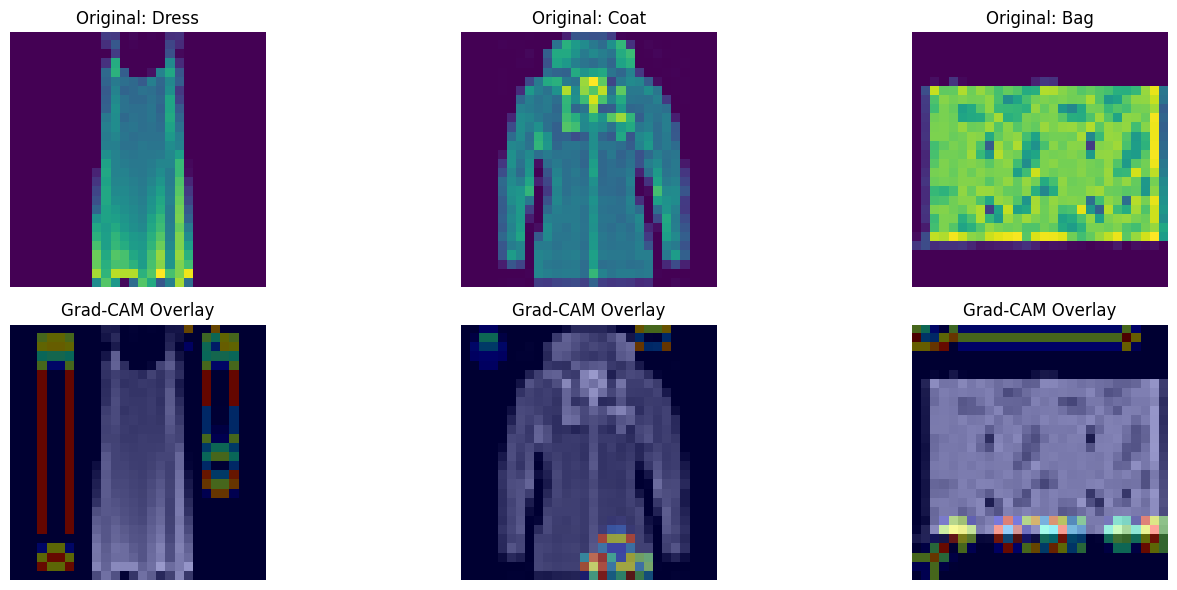

In [18]:
# --- Setup: move to repo root + make src importable ---
import os, sys
from pathlib import Path

#root = Path("..").resolve()   # notebook is in notebooks/, go up one level
os.chdir(root)
sys.path.append(str(root))
print("Working dir:", os.getcwd())

# --- Imports from your explain tool ---
from src.explain import load_model, get_transforms_from_meta, run_gradcam, get_device

# --- Other deps ---
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import json
import random

# --- 1) Find the latest best checkpoint ---
reports = sorted(Path("reports").glob("*fmnist"), key=lambda p: p.stat().st_mtime)
assert reports, "No Fashion-MNIST runs found in reports/. Train once with the Fashion-MNIST config."
latest = reports[-1]
best_json = json.loads((latest / "best.json").read_text())
best_ckpt = Path(best_json["ckpt_path"])
print("Using checkpoint:", best_ckpt)

# --- 2) Load model & dataset transforms/classes ---
device = get_device("auto")
model, classes_from_ckpt, meta = load_model(str(best_ckpt), device)
tf = get_transforms_from_meta(meta)
classes = classes_from_ckpt or default_classes

# --- 3) Prepare some test samples (from the official test split) ---
test_raw = FashionMNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

indices = random.sample(range(len(test_raw)), 3)  # pick any indices you want
outdir = Path("reports") / best_ckpt.parent.name / "explain_direct"
outdir.mkdir(parents=True, exist_ok=True)

# --- 4) Run Grad-CAM directly (no subprocess) ---
overlay_files = []
for i in indices:
    img, label = test_raw[i]                      # img is tensor [1,28,28] in [0,1]
    pil = transforms.ToPILImage()(img).convert("RGB")  # convert to PIL RGB for our tf
    x = tf(pil)                                   # normalized tensor [1,28,28]
    results = run_gradcam(model, "conv2", x, device, classes, outdir, topk=1)
    overlay_files.append(results[0]["file"])

print("Saved overlays:", overlay_files)

# --- 5) Display overlays inline ---
plt.figure(figsize=(15, 6))

# Display original images
for i, idx in enumerate(indices):
    plt.subplot(2, len(indices), i+1)
    img, label = test_raw[idx]
    plt.imshow(transforms.ToPILImage()(img))
    plt.title(f'Original: {classes[label]}')
    plt.axis('off')

# Display overlay images
for i, overlay_file in enumerate(overlay_files):
    plt.subplot(2, len(indices), len(indices) + i+1)
    overlay = Image.open(overlay_file)
    plt.imshow(overlay)
    plt.title('Grad-CAM Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()

Working dir: /Users/stefanoracca/Desktop/projects/computer-vision-explainable-cnn
Using checkpoint: reports/resnet18_cifar10/best.ckpt
Meta: {'dataset': 'cifar10', 'model_name': 'resnet18_cifar', 'img_size': 32, 'default_target_layer': 'layer4'}
Saved: reports/resnet18_cifar10/explain_direct
Saved: reports/resnet18_cifar10/explain_direct
Saved: reports/resnet18_cifar10/explain_direct
Saved overlays: ['reports/resnet18_cifar10/explain_direct/gradcam_top1_class3_cat.png', 'reports/resnet18_cifar10/explain_direct/gradcam_top1_class0_airplane.png', 'reports/resnet18_cifar10/explain_direct/gradcam_top1_class7_horse.png']


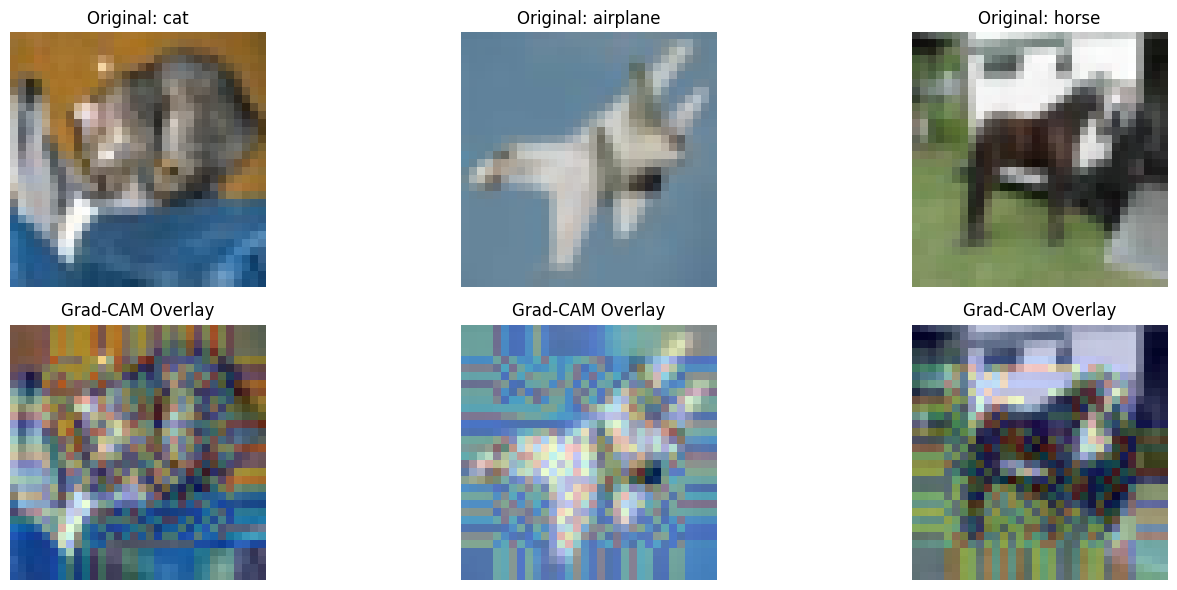

In [1]:
# --- Setup: move to repo root + make src importable ---
import os, sys, json
from pathlib import Path

root = Path("..").resolve()   # notebook is in notebooks/, go up one level
os.chdir(root)
sys.path.append(str(root))
print("Working dir:", os.getcwd())

# --- Imports from your explain tool ---
# (make sure your explain.py exposes these: load_model, get_transforms_from_meta, run_gradcam, get_device)
from src.explain import load_model, get_transforms_from_meta, run_gradcam, get_device

# --- Other deps ---
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import CIFAR10
from torchvision import transforms

# --- 1) Find the latest CIFAR-10 best checkpoint (by reading reports/*/best.json) ---
reports = sorted(Path("reports").glob("*cifar10"), key=lambda p: p.stat().st_mtime)
assert reports, "No CIFAR-10 runs found in reports/. Train once with the CIFAR config."
latest = reports[-1]
best_json = json.loads((latest / "best.json").read_text())
best_ckpt = Path(best_json["ckpt_path"])
print("Using checkpoint:", best_ckpt)

# --- 2) Load model & transforms from checkpoint meta ---
device = get_device("auto")
model, classes, meta = load_model(str(best_ckpt), device)
tf = get_transforms_from_meta(meta)
target_layer = meta.get("default_target_layer", "layer4")  # ResNet18 default

print("Meta:", {k: meta.get(k) for k in ["dataset","model_name","img_size","default_target_layer"]})

# --- 3) Prepare CIFAR-10 test samples (raw tensors -> PIL -> normalized via tf) ---
test_raw = CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())

# pick any indices you want
indices = [0, 10, 20]
outdir = Path("reports") / latest.name / "explain_direct"
outdir.mkdir(parents=True, exist_ok=True)

# --- 4) Run Grad-CAM directly (no subprocess) ---
overlay_files = []
for i in indices:
    img, label = test_raw[i]                       # img is tensor [3,32,32] in [0,1]
    pil = transforms.ToPILImage()(img)             # PIL RGB
    x = tf(pil)                                    # normalized tensor [3,H,W] based on meta
    results = run_gradcam(model, target_layer, x, device, classes, outdir, topk=1)
    overlay_files.append(results[0]["file"])

print("Saved overlays:", overlay_files)

# --- 5) Display original images and overlays inline ---
plt.figure(figsize=(15, 6))

# Display original images
for i, idx in enumerate(indices):
    plt.subplot(2, len(indices), i+1)
    img, label = test_raw[idx]
    plt.imshow(transforms.ToPILImage()(img))
    plt.title(f'Original: {classes[label]}')
    plt.axis('off')

# Display overlay images
for i, overlay_file in enumerate(overlay_files):
    plt.subplot(2, len(indices), len(indices) + i+1)
    overlay = Image.open(overlay_file)
    plt.imshow(overlay)
    plt.title('Grad-CAM Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
from pathlib import Path
import json, pandas as pd

rows = []
for best in Path("../reports").rglob("best.json"):
    j = json.loads(best.read_text())
    # find metrics.json in same run folder
    metrics = json.loads((best.parent / "metrics.json").read_text())
    rows.append({
        "run_id": best.parent.name,
        "val_acc": j["val_acc"],
        "val_loss": j["val_loss"],
        "epoch": j["epoch"],
    })

df = pd.DataFrame(rows).sort_values("val_acc", ascending=False)
df

,run_id,val_acc,val_loss,epoch
1,smallcnn_aug_fmnist,0.9161,0.246326,11
0,smallcnn_fmnist,0.9125,0.251245,7
